In [1]:
!pip install shap==0.45.0 --no-cache-dir --user


In [3]:
import pandas as pd
file = r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv"
df = pd.read_csv(file)


In [4]:
import pickle

with open(r"C:\Users\rjesh\vre_reports\xgboost_model.pkl", "rb") as f:
    model = pickle.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rjesh\\vre_reports\\xgboost_model.pkl'

In [5]:
import pickle

model_path = r"C:\Users\rjesh\vre_reports\xgboost_model.pkl"

with open(model_path, "rb") as f:
    model = pickle.load(f)

print("Model loaded successfully.")


Model loaded successfully.


In [6]:
import pandas as pd

df = pd.read_csv(r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv")

X = df.drop(["PNL_Energy_MU"], axis=1)  # features
y = df["PNL_Energy_MU"]                 # target


In [7]:
import shap

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Bar plot
shap.plots.bar(shap_values, max_display=20)


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [8]:
df_ml = pd.read_csv(r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv")

print(df_ml.dtypes)
print("\nObject columns:")
print(df_ml.select_dtypes(include="object").columns.tolist())


Date                           object
Total_Demand                  float64
Total_Energy                  float64
Total_Solar                   float64
Total_Wind                    float64
Total_Hydro                   float64
Total_VRE_MU                  float64
PNL_Energy_MU                 float64
PNL_peak_PSP_MW               float64
max_wind_mw                     int64
max_wind_time                  object
max_solar_mw                    int64
max_solar_time                 object
max_vre_mw                      int64
max_vre_time                   object
max_wind_penetration_pct      float64
max_wind_penetration_time      object
max_solar_penetration_pct     float64
max_solar_penetration_time     object
max_vre_penetration_pct       float64
max_vre_penetration_time       object
wind_schedule_mu              float64
wind_actual_mu                float64
wind_deviation_mu             float64
wind_cuf_pct                  float64
solar_schedule_mu             float64
solar_actual

In [9]:
base_features = [
    # system & VRE
    "Total_Demand",
    "Total_Solar",
    "Total_Wind",
    "Total_Hydro",
    "Total_VRE_MU",
    "PNL_peak_PSP_MW",
    "wind_actual_mu",
    "solar_actual_mu",
    "wind_cuf_pct",
    "solar_cuf_pct",

    # weather
    "ALLSKY_SFC_SW_DWN",
    "T2M",
    "WS10M",
    "WS50M",
    "RH2M",

    # temporal
    "Month",
    "DayOfWeek",
    "DoY_sin",
    "DoY_cos",

    # dynamic behaviour
    "NetLoad_Ramp",
    "Ramp_lag1",
    "PNL_lag1",
    "PNL_lag2",
    "PNL_lag7",
    "PNL_roll_mean_3",
    "PNL_roll_mean_7",
    "PNL_roll_std_3",
    "PNL_roll_std_7",
    "VRE_lag1",
    "VRE_lag2",
    "VRE_lag7",
    "VRE_roll_mean_3",
]


In [10]:
import pandas as pd
import shap
import numpy as np
import pickle

# 1) Load feature matrix
df_ml = pd.read_csv(r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv")

target_col = "PNL_Energy_MU"

# Recreate the same base_features list here
base_features = [
    "Total_Demand",
    "Total_Solar",
    "Total_Wind",
    "Total_Hydro",
    "Total_VRE_MU",
    "PNL_peak_PSP_MW",
    "wind_actual_mu",
    "solar_actual_mu",
    "wind_cuf_pct",
    "solar_cuf_pct",
    "ALLSKY_SFC_SW_DWN",
    "T2M",
    "WS10M",
    "WS50M",
    "RH2M",
    "Month",
    "DayOfWeek",
    "DoY_sin",
    "DoY_cos",
    "NetLoad_Ramp",
    "Ramp_lag1",
    "PNL_lag1",
    "PNL_lag2",
    "PNL_lag7",
    "PNL_roll_mean_3",
    "PNL_roll_mean_7",
    "PNL_roll_std_3",
    "PNL_roll_std_7",
    "VRE_lag1",
    "VRE_lag2",
    "VRE_lag7",
    "VRE_roll_mean_3",
]

X = df_ml[base_features]       # ✅ only numeric columns, same as training
y = df_ml[target_col]

print("X dtypes:\n", X.dtypes)
print("Any object dtypes? ->", X.select_dtypes(include="object").columns.tolist())


X dtypes:
 Total_Demand         float64
Total_Solar          float64
Total_Wind           float64
Total_Hydro          float64
Total_VRE_MU         float64
PNL_peak_PSP_MW      float64
wind_actual_mu       float64
solar_actual_mu      float64
wind_cuf_pct         float64
solar_cuf_pct        float64
ALLSKY_SFC_SW_DWN    float64
T2M                  float64
WS10M                float64
WS50M                float64
RH2M                 float64
Month                  int64
DayOfWeek              int64
DoY_sin              float64
DoY_cos              float64
NetLoad_Ramp         float64
Ramp_lag1            float64
PNL_lag1             float64
PNL_lag2             float64
PNL_lag7             float64
PNL_roll_mean_3      float64
PNL_roll_mean_7      float64
PNL_roll_std_3       float64
PNL_roll_std_7       float64
VRE_lag1             float64
VRE_lag2             float64
VRE_lag7             float64
VRE_roll_mean_3      float64
dtype: object
Any object dtypes? -> []


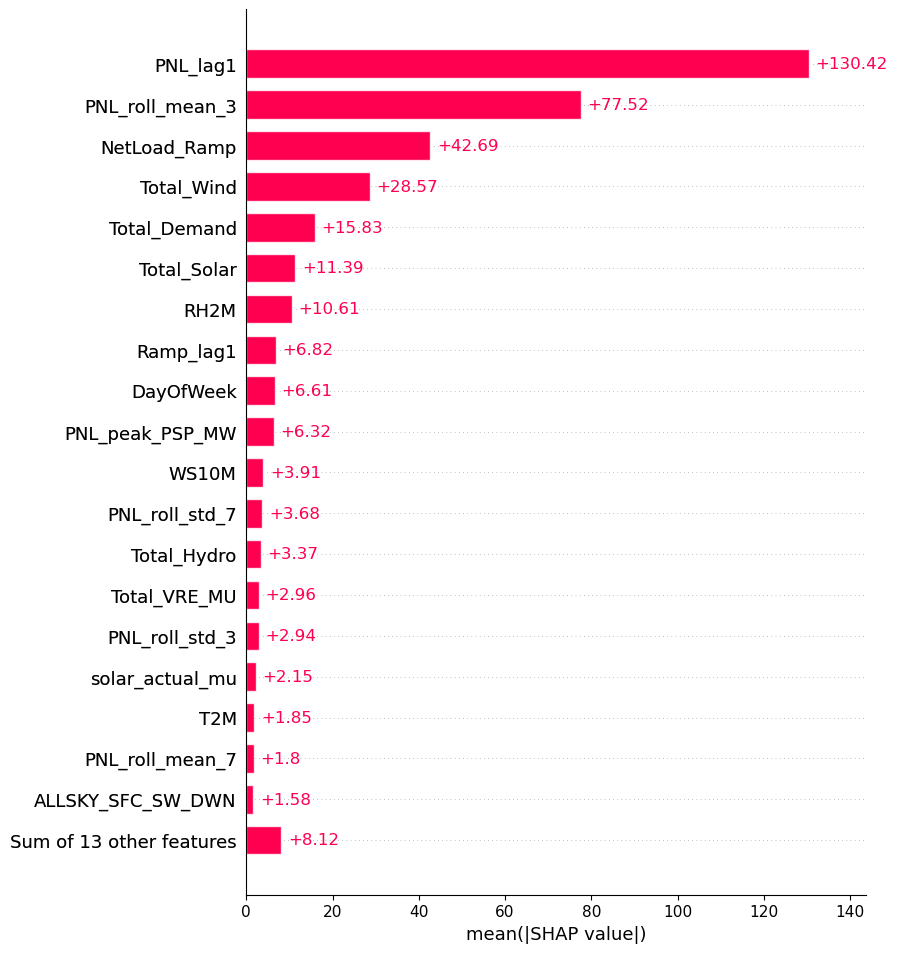

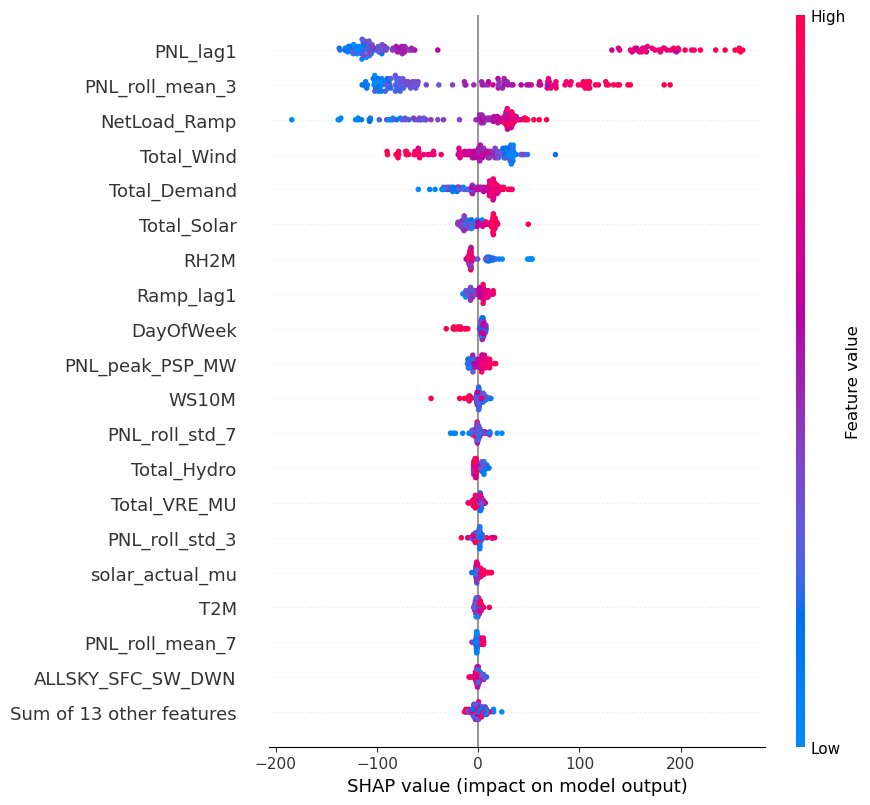

In [11]:
# Load model
with open(r"C:\Users\rjesh\vre_reports\xgboost_model.pkl", "rb") as f:
    model = pickle.load(f)

# Use a small background sample for SHAP
background = X.sample(n=min(50, len(X)), random_state=42)

explainer = shap.Explainer(model, background)
shap_values = explainer(X)

# Global importance
shap.plots.bar(shap_values, max_display=20)

# Detailed beeswarm (optional)
shap.plots.beeswarm(shap_values, max_display=20)
